In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from numpy.typing import NDArray

from karabo.imaging.image import Image
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
)
from karabo.imaging.util import project_sky_to_image
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.simulator_backend import SimulatorBackend
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


In [2]:
SIMULATOR_BACKEND = SimulatorBackend.OSKAR

## Simulation

/home/miro/miniconda3/envs/karabo/lib/python3.9/site-packages/karabo/simulation/sky_model.py:1223: KaraboWarning: Warning: flux with value <= 0 found, setting those to np.nan to avoid logarithmic errors (only affects the colorbar)
  warn(


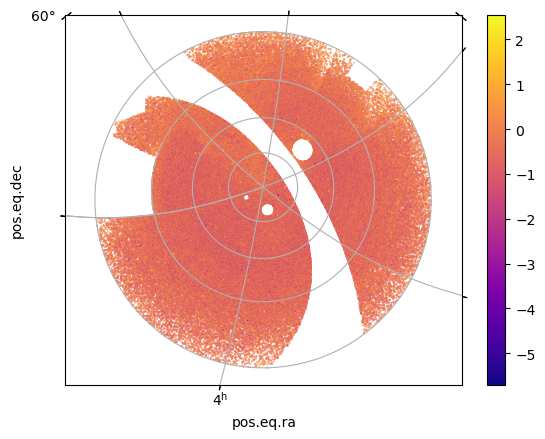

In [3]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky(min_freq=72e6, max_freq=80e6)
gleam_sky.explore_sky(phase_center, s=0.1)

Then we filter the sky model based on radius.

In [4]:
sky = gleam_sky.filter_by_radius(0, 0.55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

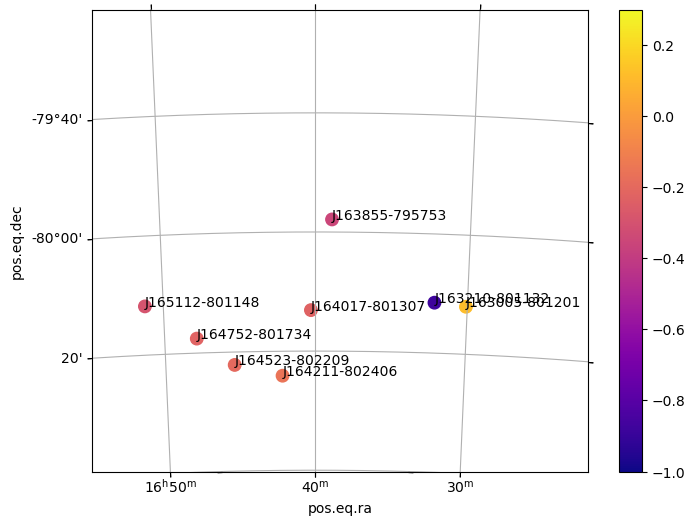

In [5]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246),  # RA-lim
    ylim=(-81, -79),  # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=0.3,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

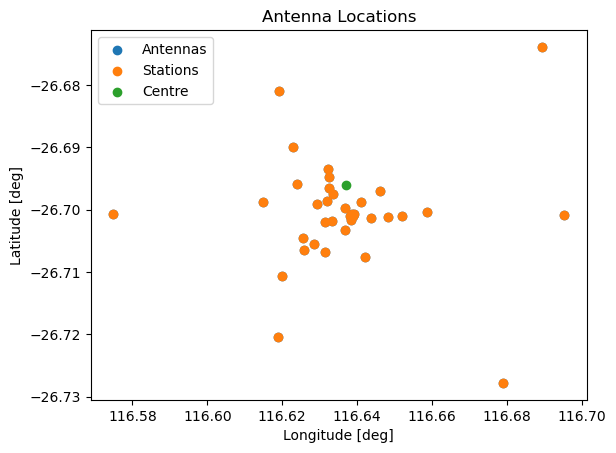

In [6]:
askap_tel = Telescope.constructor("ASKAP", backend=SIMULATOR_BACKEND)
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [7]:
from karabo.simulation.visibility import Visibility

observation_settings = Observation(
    start_frequency_hz=100e6,
    start_date_and_time=datetime(2024, 3, 15, 10, 46, 0),
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=16,
    number_of_time_steps=24,
)

# If you want, you can define where karabo should store the visibilities
# If not, karabo will decide where to store it.
vis = Visibility()
vis_path = vis.vis_path

print(f"Saving file to {vis_path}")
interferometer_sim = InterferometerSimulation(
    vis_path=vis_path, channel_bandwidth_hz=1e6
)
visibility_askap = interferometer_sim.run_simulation(
    askap_tel, sky, observation_settings, backend=SIMULATOR_BACKEND
)

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-ZRWHihuI5o for visibility disk-cache
Saving file to /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-ZRWHihuI5o/visibility.vis
Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.
Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-aAQu6gcg1n for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-ZRWHihuI5o/visibility.vis


### Imaging

To visualize the source detection, this notebook uses WSClean to obtain images. For other imaging algorithms, please refer to the imaging.ipynb notebook. 

In [8]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

#### WSClean

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-dirty-ZzDeWpH4xz for Disk cache for WSClean dirty images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-dirty-ZzDeWpH4xz && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-aAQu6gcg1n/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-aAQu6gcg1n/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-15120; 15120 rows)
Detected 15.5 GB of system memory, usag

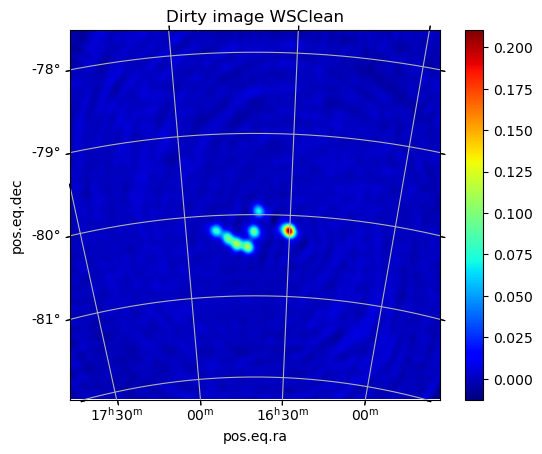

In [9]:
dirty_wsclean = WscleanDirtyImager(
    DirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibility_askap)
dirty_wsclean.plot(title="Dirty image WSClean")

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-cleaned-njhvoDImoe for Disk cache for WSClean cleaned images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-cleaned-njhvoDImoe && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -auto-threshold 3 /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-aAQu6gcg1n/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-aAQu6gcg1n/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%..

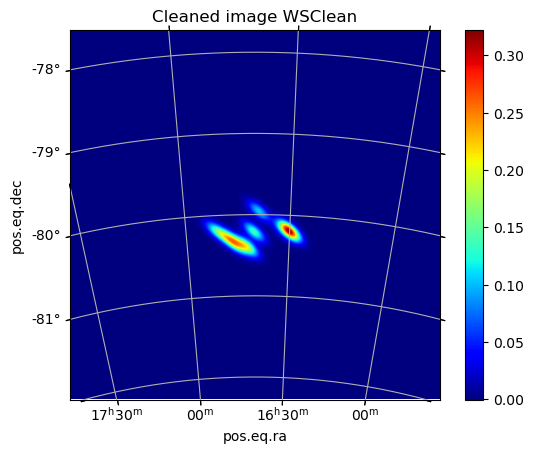

In [10]:
restored_wsclean = WscleanImageCleaner(
    WscleanImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_cleaned_image(
    ms_file_path=visibility_askap.ms_file_path,
)
restored_wsclean.plot(title="Cleaned image WSClean")

## Source Detection

In [11]:
ground_truth, sky_idxs = project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

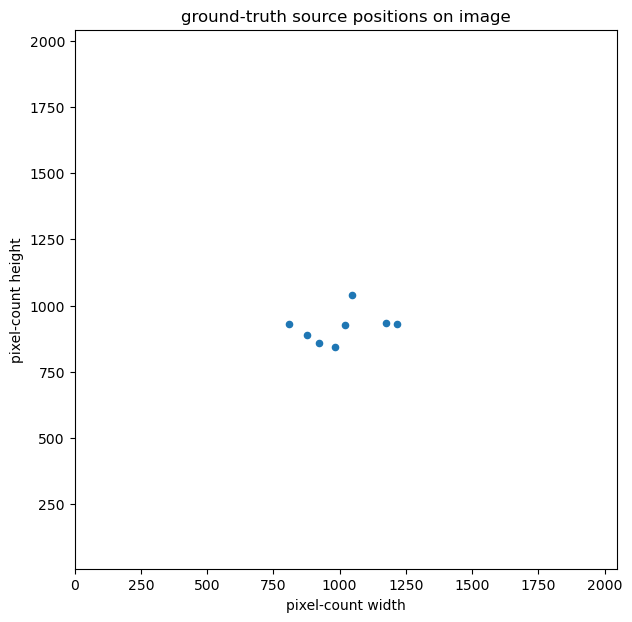

In [12]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [13]:
def detect_sources_and_evaluate(
    image: Image,
    ground_truth: NDArray[np.float64],
    sky: SkyModel,
    sky_idxs: NDArray[np.int64],
) -> SourceDetectionEvaluation:
    detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(
        image=image,
        thresh_isl=15,
        thresh_pix=20,
    )

    assignments = (
        SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
            ground_truth=ground_truth.T,
            detected=detection_result.get_pixel_position_of_sources(),
            max_dist=10,
            top_k=3,
        )
    )
    print(assignments)

    sde = SourceDetectionEvaluation(
        sky=sky,
        ground_truth=ground_truth,
        assignments=assignments,
        sky_idxs=sky_idxs,
        source_detection=detection_result,
    )
    sde.plot()

    sde.plot_confusion_matrix()

    return sde

#### WSClean

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-FjkmaBlZqQ for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-FjkmaBlZqQ/sources.csv'
--> Wrote file '/tmp/karabo-STM-miro-HHuPfzXsfQ/pybdsf-sdr-FjkmaBlZqQ/ch0-result.fits'
[[0.         4.         1.33219812]
 [1.         7.         2.93639617]
 [2.         1.         3.29958272]
 [3.         0.         1.37740907]
 [4.         2.         1.40663006]
 [5.         6.         6.64471258]
 [6.         5.         1.31574501]
 [7.         3.         1.40036402]]


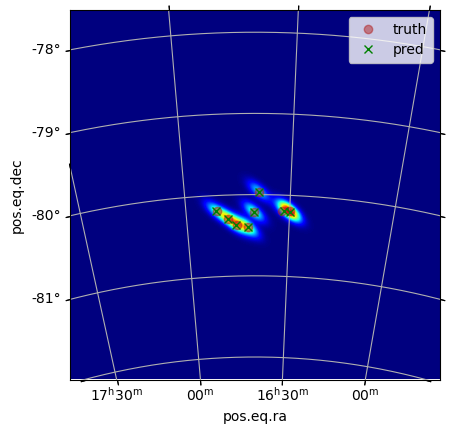

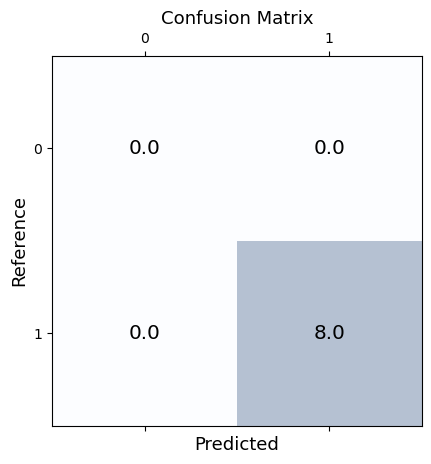

In [14]:
sde_restored_wsclean = detect_sources_and_evaluate(
    image=restored_wsclean, ground_truth=ground_truth, sky=sky, sky_idxs=sky_idxs
)

#### Additional plots

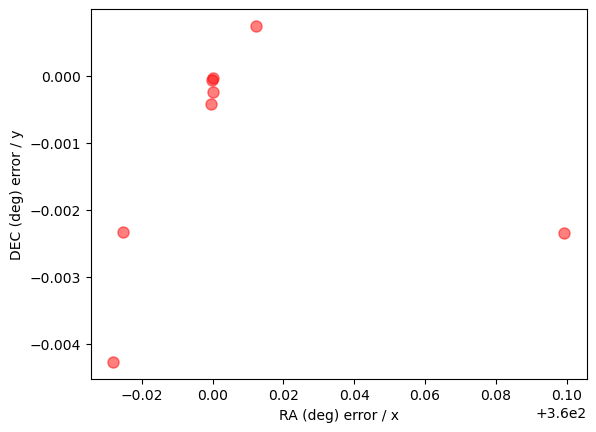

In [15]:
# Plot error ra and dec
sde_restored_wsclean.plot_error_ra_dec()

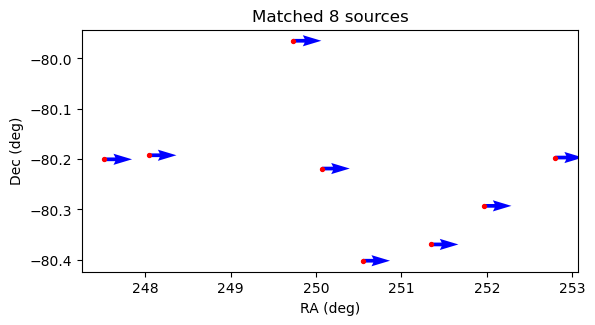

In [16]:
sde_restored_wsclean.plot_quiver_positions()

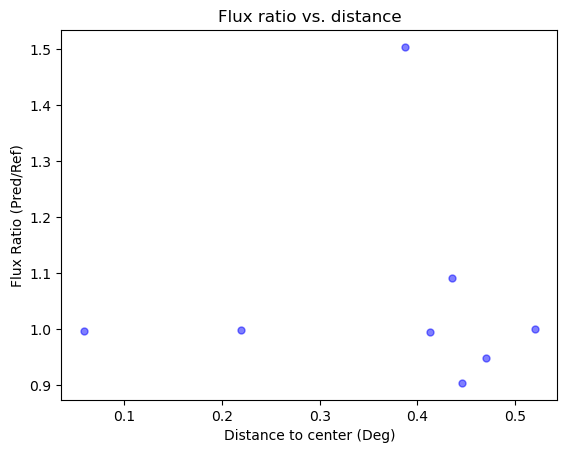

In [17]:
sde_restored_wsclean.plot_flux_ratio_to_distance()

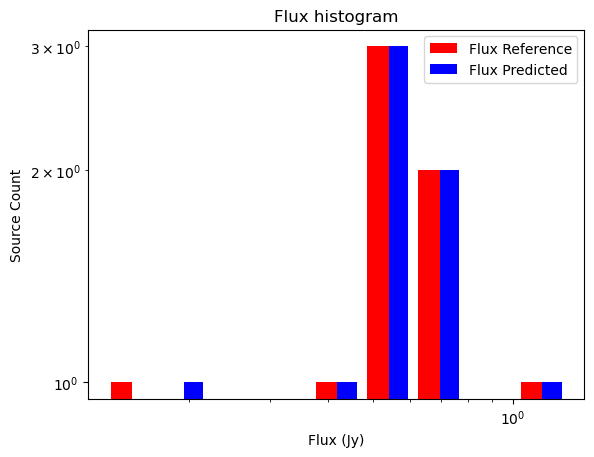

In [18]:
sde_restored_wsclean.plot_flux_histogram()

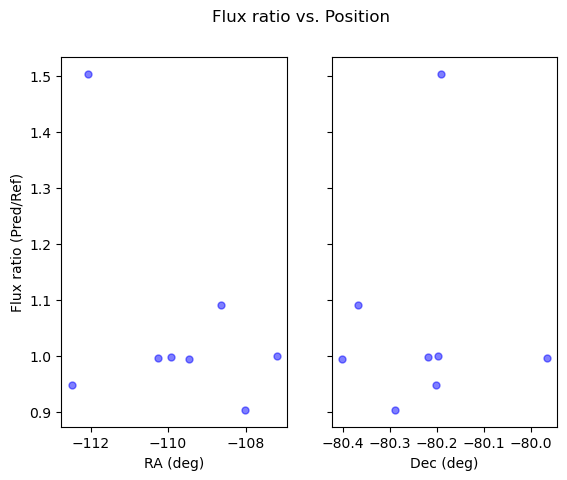

In [19]:
sde_restored_wsclean.plot_flux_ratio_to_ra_dec()